# Comparison of different Parametrization Methods for Covariance Matrix Prediction
## How to ensure positive definite Covariance Matrix Predictions?
I compared four different parametrization methods for realized covariance matrices. When forecasting realized covariance matrices it is important to ensure positive definitness of the matrices. In most forecasting models complex constraints are used. But another approach is to use parametrization methods, which are often computationally attractive and easier to calculate. I used the Cholesky Decomposition, Matrix Logarithm Function, positive semi-definite Matrix Approximant and the Matrix correlation parametrization. I forecasted based on these different parametrizations and compared the performance. The underlying data was stock data from 15 large German stocks.    

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import numpy.linalg as nplin
import scipy.linalg

from scipy.linalg import expm, logm, norm
from scipy import stats
from scipy.spatial import procrustes

import pandas as pd

import math
import matplotlib.pyplot as plt

import seaborn as sns

from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

import datetime as dt
from pandas_datareader import data as web

import yfinance as yf

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

# Different Parametrizations


In [5]:
# vech() denotes vectorization operator to get lower elements of a matrix

def vech(A):
  d = A[np.tril_indices(len(A))]

  return d

In [6]:
# vecl() denotes vectorization operator to get lower off-diagonal elements of a matrix
def vecl(A):
  b = A[np.tril_indices(len(A), k=-1)]

  return b

In [7]:
# opposite of vech: mat
def mat(v):
  n = int(-0.5+np.sqrt(0.5**2+2*v.size))

  # initalise symmetric matrix
  matrix = np.zeros((n,n))
  idx = np.tril_indices(n)

  # fill with vector
  matrix[idx] = v

  # make lower triangular matrix to symmetric matrix
  A = matrix+matrix.T-np.diag(np.diag(matrix))

  return A

In [8]:
# Psi for RC
def psiRC(l):
  psi_rc = list()

  for i in range(len(l)):
    result_rc = vech(l[i])
    psi_rc.append(result_rc)
  
  return psi_rc

1. Cholesky Decomposition

In [9]:
from scipy.linalg import cholesky

def Cholesky(A):
    '''
    Input: Matrix
    Output: lower triangular of matrix after cholesky decomposition as vector
    '''
    # if statement for psd matrices
    # if pd matrix use cholesky
    # else use cholesky Banachiewicz
    # not 0 for eigenvalues, because otherwise cholesky have difficulties
    if np.all(nplin.eigvals(A) > 0.01):
        A = A
    else:
        # Add a small multiple of the identity matrix to A to make it positive-definite
        A = A + 1e-30 * np.eye(A.shape[0]) 

    L = cholesky(A, lower=True)
    psi = vech(L)
    return psi


In [10]:
def Cholesky_Opposite(psi): 
  '''
  Input: lower triangular of matrix after cholesky decomposition as vector
  Output: matrix
  '''
  L = mat(psi)
  A = np.dot(L,L.T)

  return A

2. Matrix logarithm function

In [11]:
# just use psi = vech(logm(RC))
# for opposite RC = expm(mat(psi))

3. Spectral Decomposition: Positive semidefinite matrix approximant

In [12]:
def Approximant_matrix(A):
  '''
    Input: matrix
    Output: positive semidefinite matrix approximant if matrix was not psd
  '''
  l, v = nplin.eig(A)

  # n shows if there was a change in l
  n = 0

  # set all negative eigenvalues to zero
  for i in range(len(l)):
    if l[i] < 0:
      l[i] = 0.0
      n = 1
  
  if n == 1:
    # normalize the eigenvectors to make them orthonormal
    v = np.column_stack(scipy.linalg.orth(v))
    
    # calculate positive semidefinite matrix approximant
    RC = np.dot(v,np.dot(np.diag(l), v.T))
  else:
    RC = A
  
  return RC

In [13]:
def Approximant(l):
  '''
    Input: list of matrix
    Output: list of positive semidefinite matrix approximant if matrix was not psd
  '''
  Cov_approx = list()
  for i in range(len(l)):
    result_approx = Approximant_matrix(l[i])
    Cov_approx.append(result_approx)
  
  return Cov_approx

4. Matrix Correlation parametrization

In [14]:
def Corr(A):
  '''
    Input: matrix
    Output: d and gamma from matrix correlation parametrization
  '''

  # Decompose RC in standard deviations and correlations
  D = np.diag(np.sqrt(np.diag(A)))
  Dinv = np.linalg.inv(D)
  C = np.dot(Dinv, np.dot(A, Dinv))

  # calculate d and gamma
  d = np.log(np.diag(D))
  gamma = vecl(logm(C))

  psi = (d, gamma)

  return psi

In [15]:
# Code from Supplement Material Archakov/Hansen 2021 
# Calculate C from an estimated gamma
# need it after forecasting

def GFT_inverse_mapping(gamma_in, tol_value):
  '''
    Input: gamma, tolerance value
    Code from Supplement Material Archakov/Hansen 2021 
    Output: C and number of iterations
  '''
  C = []
  iter_number = -1

  try:
    # Check if input is of proper format: gamme is of suitable length 
    # and tolerance value belongs to a proper interval
    n = 0.5*(1+np.sqrt(1+8*len(gamma_in)))
    if not all ([gamma_in.ndim == 1, n.is_integer(),
                 1e-14 <= tol_value <= 1e-4]):
      raise ValueError
    
    # Place elements from gamma into off-diagonal parts
    # and put zeros on the main diagonal of nxn symmetric matrix A
    n = int(n)
    A = np.zeros(shape=(n,n))
    A[np.triu_indices(n,1)] = gamma_in
    A = A + A.T

    # Read properties of the input matrix
    diag_vec = np.diag(A)
    diag_ind = np.diag_indices_from(A)

    # Iterative algorithm to get the proper diagonal vector
    dist = np.sqrt(n)
    while dist > np.sqrt(n)*tol_value:
      diag_delta = np.log(np.diag(expm(A)))
      diag_vec = diag_vec - diag_delta
      A[diag_ind] = diag_vec
      dist = norm(diag_delta)
      iter_number += 1

    # Get a unique reciprocal correlation matrix
    C = expm(A)
    np.fill_diagonal(C, 1)

  except ValueError:
    print("Error: input is of wrong format")
  
  return C, iter_number

In [16]:
def Corr_Opposite(psi):
  '''
    Input: psi with gamma and d
    Output: Covariancematrix A
  '''

  # Split psi in two lists
  d = psi[0]
  gamma = psi[1]

  D = np.diag(np.exp(d))
  C, iter_number = GFT_inverse_mapping(gamma, 0.0000001)

  A = np.dot(D,np.dot(C,D))

  return A

In [17]:
def parametrize(l):
  '''
    Input: list of covariance matrices
    combines all paramtrization methods
    Output: different psi
  '''
  psi_logm = list()
  psi_corr = list()
  psi_chol = list()

  for i in range(len(l)):
    # Cholesky
    result_chol = Cholesky(l[i])
    psi_chol.append(result_chol)

    # Matrix logarithm
    result_logm = vech(logm(l[i]))
    psi_logm.append(result_logm)

    # Matrix Correlation parametrization
    result_corr = Corr(l[i])
    psi_corr.append(result_corr)
  
  psi_rc = psiRC(l)

  return psi_rc, psi_chol, psi_logm, psi_corr

In [18]:
def reverse_parametrize(prediction_rc, prediction_chol, prediction_logm, prediction_corr):
  '''
    Input: different predictions of psi
    Reversing parametrizations, calculate covariance matrices
    Output: different predictions of covariance matrix
  '''
  Cov_corr = list()
  Cov_logm = list()
  Cov_rc = list()
  Cov_chol = list()
  
  for i in range(len(prediction_logm)):
    # Calculate matrices from predicted psi
    result_chol = Cholesky_Opposite(prediction_chol[i])
    result_corr = Corr_Opposite(prediction_corr[i])
    result_logm = expm(mat(prediction_logm[i]))
    result_rc = mat(prediction_rc[i])

    # append to list
    Cov_chol.append(result_chol)
    Cov_corr.append(result_corr)
    Cov_logm.append(result_logm)
    Cov_rc. append(result_rc)
  
  return Cov_rc, Cov_chol, Cov_logm, Cov_corr

# VAR Model

In [19]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [20]:
def VAR_model(list, h):

  '''
  Input: List with observed Psi, h forecast horizon

  Predict VAR with Rolling window 

  Ouput: Out-of-Sample predictions
  '''

  # List in Dataframe
  df = pd.DataFrame(list)

  # test size is 1/3 of observations
  test_size = round(1/3*len(df))

  rolling_predictions = []

  # T2 depends on forecast horzion p. 89 Bucci
  for i in range(test_size-(h-1)):
    # Rolling Window for training set
    train = df[i:-(test_size-i)]

    # fit VAR model
    model = VAR(train)

    result = model.fit()
    
    lag_order = result.k_ar
    pred = result.forecast(train.values[-lag_order:], h)  

    # prediction to list
    rolling_predictions.append(pred[0])

  return rolling_predictions

In [21]:
# Predictions
def prediction(psi_rc, psi_chol, psi_logm, psi_corr, h):
  '''
    Input: different psi, forecast horizont h
    apply VAR 
    Output: predictions of psi
  '''
  # Prediction Cholesky
  prediction_chol = VAR_model(psi_chol, h)
  # Prediction logm
  prediction_logm = VAR_model(psi_logm, h)

  # Prediction RC
  prediction_rc = VAR_model(psi_rc, h)

  # Prediction corr
  prediction_corr = list()
  d, gamma = zip(*psi_corr)

  prediction_d = VAR_model(d, h)
  prediction_gamma = VAR_model(gamma, h)

  for i in range(len(prediction_d)):
    result_corr = (prediction_d[i], prediction_gamma[i])
    prediction_corr.append(result_corr)
  
  return prediction_rc, prediction_chol, prediction_logm, prediction_corr



# Predictive Accuracy


In [22]:
from scipy.spatial import procrustes
from collections import namedtuple

In [23]:
def Accuracy(Cov_rc, Cov_chol, Cov_logm, Cov_approx, Cov_corr, RC):
  '''
    Input: different Covariances
    Calculates Procrustes and Frobenius norm
    Output: Procrustes and Frobenius norm for different parametrizations
  '''
  n = len(Cov_logm)
  names = np.array(["RC", "Cholesky", "Logm", "Approx", "Corr"])

  logm1 = np.zeros(n)
  logm2 = np.zeros(n)
  rc1 = np.zeros(n)
  rc2 = np.zeros(n)
  chol1 = np.zeros(n)
  chol2 = np.zeros(n)
  corr1 = np.zeros(n)
  corr2 = np.zeros(n)
  approx1 = np.zeros(n)
  approx2 = np.zeros(n)

  for i in range(n):
    # Procrustes
    rc1[i] = procrustes(RC[-i], Cov_rc[-i])[2]
    chol1[i] = procrustes(RC[-i], Cov_chol[-i])[2]
    logm1[i] = procrustes(RC[-i], Cov_logm[-i])[2]
    approx1[i] = procrustes(RC[-i], Cov_approx[-i])[2]
    corr1[i] = procrustes(RC[-i], Cov_corr[-i])[2]
    # Frobenius Norm
    rc2[i] = nplin.norm(RC[-i]-Cov_rc[-i])
    chol2[i] = nplin.norm(RC[-i]-Cov_chol[-i])
    logm2[i] = nplin.norm(RC[-i]-Cov_logm[-i])
    approx2[i] = nplin.norm(RC[-i]-Cov_approx[-i])
    corr2[i] = nplin.norm(RC[-i]-Cov_corr[-i])
  
  l = np.array([round(rc1.mean(), 5), round(chol1.mean(), 5), round(logm1.mean(), 5),
       round(approx1.mean(), 5), round(corr1.mean(), 5)])
  b = np.array([round(rc2.mean(), 2), round(chol2.mean(), 2), round(logm2.mean(), 2),
       round(approx2.mean(), 2), round(corr2.mean(), 2)])
  
  accuracy = pd.DataFrame([l, b]).T


  return accuracy

# Stockdata



In [24]:
# s20 years of daily stock data

start = pd.Timestamp('2003-01-01')
end = pd.Timestamp('2023-01-01')

mercedes = yf.download('MBG.DE', start, end)
allianz = yf.download('ALV.DE', start, end)
sap = yf.download('SAP.DE', start, end)
siemens = yf.download('SIE.DE', start, end)
telekom = yf.download('DTE.DE', start, end)
bayer = yf.download('BAYN.DE', start, end)
basf = yf.download('BAS.DE', start, end)
rück = yf.download('MUV2.DE', start, end)
infineon = yf.download('IFX.DE', start, end)
post = yf.download('DPW.DE', start, end)
boerse = yf.download('DB1.DE', start, end)
rwe = yf.download('RWE.DE', start, end)
volkswagen = yf.download('VOW3.DE', start, end)
bmw = yf.download('BMW.DE', start, end)
merck = yf.download('MRK.DE', start, end)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [25]:
# Returns as percentage price changes
def returns(df):
  df['Return'] = 100 * (df['Close'].pct_change())
  df['Log_Return'] = np.log(df['Close']).diff().mul(100) # rescale to faciliate optimization
  df = df.dropna()

  return df

In [26]:
mercedes = returns(mercedes)
allianz = returns(allianz)
sap = returns(sap)
siemens = returns(siemens)
telekom = returns(telekom)
bayer = returns(bayer)
basf = returns(basf)
rück = returns(rück)
infineon = returns(infineon)
post = returns(post)
boerse = returns(boerse)
rwe = returns(rwe)
vw = returns(volkswagen)
bmw = returns(bmw)
merck = returns(merck)

In [27]:
# one data frame with all returns
# concenate dataframes along axis = 0
data = pd.concat([allianz['Return'], sap['Return'], 
                  siemens['Return'], telekom['Return'], mercedes['Return'], bayer['Return'],
                 basf['Return'],rück['Return'],infineon['Return'],
                 post['Return'],boerse['Return'],rwe['Return'],
                 vw['Return'],bmw['Return'],merck['Return']],axis = 1)

# Change names
data.columns.values[0] = "Allianz"
data.columns.values[1] = "SAP"
data.columns.values[2] = "Siemens"
data.columns.values[3] = "Telekom"
data.columns.values[4] = "Mercedes"
data.columns.values[5] = "Bayer"
data.columns.values[6] = "BASF"
data.columns.values[7] = "Muenchner Rueck"
data.columns.values[8] = "Infineon"
data.columns.values[9] = "Deutsche Post"
data.columns.values[10] = "Deutsche Boerse"
data.columns.values[11] = "RWE"
data.columns.values[12] = "VW"
data.columns.values[13] = "BMW"
data.columns.values[14] = "Merck"

In [28]:
pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 907.3/907.3 KB 13.2 MB/s eta 0:00:00


In [29]:
# check stationarity of log returns
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import ADF, PhillipsPerron

In [30]:
def stationarity(df, sig_level):
  # ADF Test
  # H0 is non stationary
  p_adf = ADF(df).pvalue
  stat_adf = np.round(ADF(df).stat,4)

  # KPSS Test
  # H0 is stationary
  p_kpss = kpss(df)[1]
  stat_kpss = np.round(kpss(df)[0],4)

  # Phillips-Perron Testing
  p_pp = PhillipsPerron(df).pvalue
  stat_pp = np.round(PhillipsPerron(df).stat, 4)

  stationary = False

  if p_adf < sig_level and p_kpss > sig_level and p_pp < sig_level:
    stationary = True
  

  return stationary, stat_adf, p_adf, stat_kpss, p_kpss, stat_pp, p_pp


In [31]:
for i in range(15):
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print(stationarity(data[data.columns[i]], 0.01))


(True, -13.9903, 4.028182592042453e-26, 0.0218, 0.1, -69.984, 0.0)
(True, -15.0525, 9.248831851892348e-28, 0.0864, 0.1, -72.2748, 0.0)
(True, -18.0905, 2.570923528222087e-30, 0.0438, 0.1, -72.2076, 0.0)
(True, -20.4206, 0.0, 0.06, 0.1, -75.5034, 0.0)
(True, -12.792, 7.044238317767152e-24, 0.0358, 0.1, -68.4504, 0.0)
(True, -19.0585, 0.0, 0.3127, 0.1, -74.1997, 0.0)
(True, -14.1816, 1.9244540625638161e-26, 0.269, 0.1, -71.8758, 0.0)
(True, -25.9713, 0.0, 0.0562, 0.1, -70.6503, 0.0)
(True, -12.0093, 3.2086375761151044e-22, 0.0407, 0.1, -68.5031, 0.0)
(True, -20.7917, 0.0, 0.0639, 0.1, -70.6604, 0.0)
(True, -23.0534, 0.0, 0.0599, 0.1, -72.446, 0.0)
(True, -20.1522, 0.0, 0.1814, 0.1, -70.5895, 0.0)
(True, -19.141, 0.0, 0.1599, 0.1, -67.929, 0.0)
(True, -13.4894, 3.127214439251857e-25, 0.0624, 0.1, -69.7622, 0.0)
(True, -73.9207, 0.0, 0.0958, 0.1, -74.2042, 0.0)


In [32]:
# monthly data
# 20 years and one additional month because first observation lost when calculating returns
start = pd.Timestamp('2002-12-01')
end = pd.Timestamp('2023-01-01')

mercedes = yf.download('MBG.DE', start, end, interval = "1mo")
allianz = yf.download('ALV.DE', start, end, interval = "1mo")
sap = yf.download('SAP.DE', start, end, interval = "1mo")
siemens = yf.download('SIE.DE', start, end, interval = "1mo")
telekom = yf.download('DTE.DE', start, end, interval = "1mo")
bayer = yf.download('BAYN.DE', start, end, interval = "1mo")
basf = yf.download('BAS.DE', start, end, interval = "1mo")
rück = yf.download('MUV2.DE', start, end, interval = "1mo")
infineon = yf.download('IFX.DE', start, end, interval = "1mo")
post = yf.download('DPW.DE', start, end, interval = "1mo")
boerse = yf.download('DB1.DE', start, end, interval = "1mo")
rwe = yf.download('RWE.DE', start, end, interval = "1mo")
volkswagen = yf.download('VOW3.DE', start, end, interval = "1mo")
bmw = yf.download('BMW.DE', start, end, interval = "1mo")
merck = yf.download('MRK.DE', start, end, interval = "1mo")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [33]:
mercedes = returns(mercedes)
allianz = returns(allianz)
sap = returns(sap)
siemens = returns(siemens)
telekom = returns(telekom)
bayer = returns(bayer)
basf = returns(basf)
rück = returns(rück)
infineon = returns(infineon)
post = returns(post)
boerse = returns(boerse)
rwe = returns(rwe)
vw = returns(volkswagen)
bmw = returns(bmw)
merck = returns(merck)

In [34]:
# one data frame with all returns
# concenate dataframes along axis = 0
data_monthly = pd.concat([allianz['Return'], sap['Return'], 
                  siemens['Return'], telekom['Return'], mercedes['Return'], bayer['Return'],
                 basf['Return'],rück['Return'],infineon['Return'],
                 post['Return'],boerse['Return'],rwe['Return'],
                 vw['Return'],bmw['Return'],merck['Return']],axis = 1)

# Change names
data_monthly .columns.values[0] = "Allianz"
data_monthly .columns.values[1] = "SAP"
data_monthly .columns.values[2] = "Siemens"
data_monthly .columns.values[3] = "Telekom"
data_monthly .columns.values[4] = "Mercedes"
data_monthly .columns.values[5] = "Bayer"
data_monthly .columns.values[6] = "BASF"
data_monthly .columns.values[7] = "Muenchner Rueck"
data_monthly .columns.values[8] = "Infineon"
data_monthly .columns.values[9] = "Deutsche Post"
data_monthly .columns.values[10] = "Deutsche Boerse"
data_monthly .columns.values[11] = "RWE"
data_monthly .columns.values[12] = "VW"
data_monthly .columns.values[13] = "BMW"
data_monthly .columns.values[14] = "Merck"

In [35]:
# stationarity of monthly data
for i in range(15):
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print(stationarity(data_monthly[data_monthly.columns[i]], 0.01))

(True, -7.6696, 1.606955595098938e-11, 0.0477, 0.1, -17.2438, 6.083860691345698e-30)
(True, -8.7176, 3.4536407062887626e-14, 0.1443, 0.1, -17.539, 4.198666274227725e-30)
(True, -15.2206, 5.491808250665542e-28, 0.0615, 0.1, -15.3545, 3.6825514473680523e-28)
(True, -12.6105, 1.659684864579194e-23, 0.1275, 0.1, -16.8055, 1.210743359276083e-29)
(True, -15.1494, 6.830762729112869e-28, 0.0414, 0.1, -15.1484, 6.851489639012632e-28)
(True, -15.8363, 9.80927818089156e-29, 0.3801, 0.0857310974924432, -15.9142, 8.059775903256678e-29)
(True, -14.3449, 1.0448631551869386e-26, 0.3132, 0.1, -14.327, 1.116424151272572e-26)
(True, -7.8019, 7.454017667380853e-12, 0.093, 0.1, -22.7523, 0.0)
(True, -8.1127, 1.213598936917614e-12, 0.0388, 0.1, -11.2129, 2.1035977728076595e-20)
(True, -6.6121, 6.340188184254376e-09, 0.0669, 0.1, -15.0892, 8.240410428932335e-28)
(True, -9.5341, 2.839938151650453e-16, 0.0832, 0.1, -14.6974, 2.9838274546816944e-27)
(True, -15.7435, 1.2476052549144031e-28, 0.192, 0.1, -15.7479,

In [36]:
# data as csv for upload in R for the multivariate GARCH models
data_monthly.to_csv("returns.csv", index = False)

In [37]:
# extract the year and month from the datetime object
data['year'] = data.index.year
data['month'] = data.index.month

In [38]:
# calculate covariance matrix for every month, n is weekly, monthly etc, n=5 is weekly
# n = 21 is monthly
def realized_Cov(df, n_stocks):
  '''
  Input: dataframe of log returns
  Output: realized Covariances as list
  ''' 
  RC = list()


  for y in range(2003,2023):
    year = df.loc[df['year'] == y]
    for m in range(1,13):
      d = year.loc[year['month'] == m]
      d = d.iloc[:,0:n_stocks]
      result = np.zeros((len(d.columns), len(d.columns)))
      for j in range(len(d)):
        a = np.asarray([d.iloc[j,:]])
        b = np.dot(a.T,a)
        result = result+b

      RC.append(result)
  
  return RC


In [39]:
# Calculate RC for 5, 10 and 15 stocks
RC5 = realized_Cov(data,5)
RC10 = realized_Cov(data, 10)
RC15 = realized_Cov(data, 15)

In [40]:
# function for checking definitness
def definitness(l):
  '''
  Input: List of matrices
  Output: counter for not at least positive definite matrix
  if i = 0 all matrices at least positive definite
  '''
  i = 0
  for j in range(len(l)):
    # use not zero because of computational erros when using matrix approximant
    if np.all(nplin.eigvals(l[j]) >= -10**(-5)):
      i += 0
    else:
      i += 1

  return i

In [41]:
# Check if matrizes are at least positive semidefinite
definitness(RC5), definitness(RC10), definitness(RC15)

(0, 0, 0)

## Descriptive Statistics

In [42]:
# average return
data_monthly.mean()

Allianz            0.716951
SAP                0.925286
Siemens            0.777130
Telekom            0.350044
Mercedes           0.742797
Bayer              0.679643
BASF               0.674165
Muenchner Rueck    0.706481
Infineon           1.652971
Deutsche Post      0.844862
Deutsche Boerse    0.969767
RWE                0.596039
VW                 1.285028
BMW                0.768044
Merck              1.365335
dtype: float64

In [43]:
# maximum and minimum return per month
data_monthly.max(), data_monthly.min()

(Allianz             39.537437
 SAP                 32.181436
 Siemens             18.646833
 Telekom             18.496538
 Mercedes            42.269395
 Bayer               30.904733
 BASF                30.295310
 Muenchner Rueck     70.476190
 Infineon           131.609253
 Deutsche Post       30.520237
 Deutsche Boerse     24.738867
 RWE                 24.679805
 VW                  37.903133
 BMW                 26.333079
 Merck               22.673342
 dtype: float64, Allianz           -39.738262
 SAP               -31.086169
 Siemens           -29.338403
 Telekom           -19.937649
 Mercedes          -26.691530
 Bayer             -25.259297
 BASF              -22.755556
 Muenchner Rueck   -37.185931
 Infineon          -48.108125
 Deutsche Post     -41.474968
 Deutsche Boerse   -52.393133
 RWE               -29.313985
 VW                -44.905147
 BMW               -26.291685
 Merck             -19.713260
 dtype: float64)

In [44]:
# average variance
var = []
for i in range(len(RC15)):
  var.append(np.diag(RC15[i]))

var = pd.DataFrame(var)
names = np.array(["Allianz", "SAP", "Siemens", "Telekom", "Mercedes", "Bayer", "BASF",
          "Muenchner Rueck", "Infineon", "Deutsche Post", "Deutsche Boerse", 
          "RWE", "VW", "BMW", "Merck"])
var.columns = names

var.mean()

# Infineon largest varaince on average and Telekom smallest

Allianz             83.314767
SAP                 58.065001
Siemens             73.194316
Telekom             50.673959
Mercedes            99.726628
Bayer               79.157116
BASF                69.421461
Muenchner Rueck     64.445111
Infineon           168.306418
Deutsche Post       68.043024
Deutsche Boerse     88.160305
RWE                 82.873100
VW                 117.569837
BMW                 81.497336
Merck               60.733141
dtype: float64

In [45]:
var.max(), var.min()

(Allianz            1758.678838
 SAP                 863.919844
 Siemens            1627.409486
 Telekom             914.145792
 Mercedes           1812.928893
 Bayer              1782.451207
 BASF               1168.790327
 Muenchner Rueck    1059.891255
 Infineon           2521.598427
 Deutsche Post      1203.130443
 Deutsche Boerse    2510.327415
 RWE                 974.320843
 VW                 1942.384565
 BMW                 818.869228
 Merck               467.737684
 dtype: float64, Allianz             4.160861
 SAP                 6.354936
 Siemens             4.304891
 Telekom             4.019180
 Mercedes            7.085052
 Bayer              12.308163
 BASF                7.402388
 Muenchner Rueck     5.092818
 Infineon           14.453312
 Deutsche Post       7.702516
 Deutsche Boerse     6.359611
 RWE                 9.449589
 VW                  7.963550
 BMW                 7.200511
 Merck               8.135889
 dtype: float64)

# Plot of Data

[Text(0, 0, '2004'),
 Text(0, 0, '2008'),
 Text(0, 0, '2012'),
 Text(0, 0, '2016'),
 Text(0, 0, '2020')]

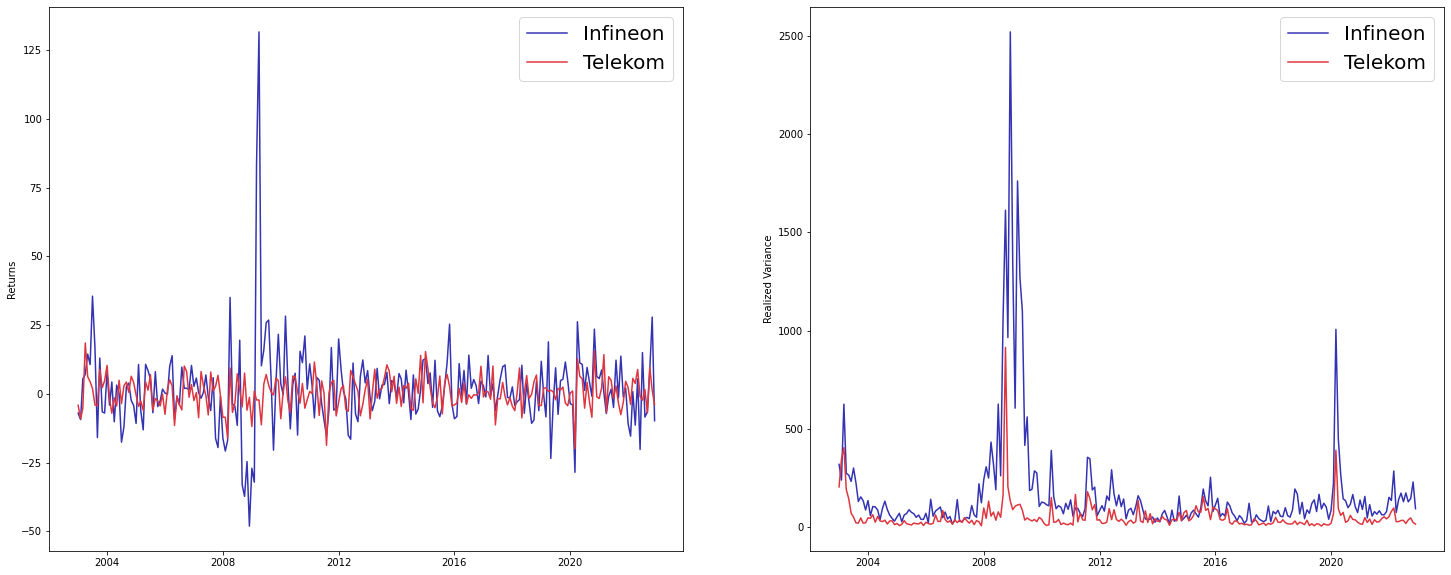

In [46]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
plt.rcParams['font.size'] = 20

# plot returns
axs[0].plot(data_monthly['Infineon'], label = 'Infineon', color = '#3333B3')
axs[0].plot(data_monthly['Telekom'], label = 'Telekom', color = '#DE353E')
axs[0].set_ylabel('Returns')
#axs[0].set_title('Returns')
axs[0].legend()

# plot variance
axs[1].plot(var['Infineon'], label = 'Infineon', color = '#3333B3')
axs[1].plot(var['Telekom'], label = 'Telekom', color = '#DE353E')
axs[1].set_ylabel('Realized Variance')
#axs[1].set_title('Realized Variance')
axs[1].legend()
axs[1].set_xticks([12, 60, 108, 156, 204])
axs[1].set_xticklabels([2004, 2008, 2012, 2016, 2020])

# Apply on Data

In [47]:
# Psi for all Parametrizations
psi_rc5, psi_chol5, psi_logm5, psi_corr5 = parametrize(RC5)
psi_rc10, psi_chol10, psi_logm10, psi_corr10 = parametrize(RC10)
psi_rc15, psi_chol15, psi_logm15, psi_corr15 = parametrize(RC15)



In [48]:
# Predictions with VAR
# 5 stocks
# one month ahead
prediction5_rc1, prediction5_chol1, prediction5_logm1, prediction5_corr1 = prediction(psi_rc5, psi_chol5, psi_logm5, psi_corr5, 1)
# 3 months ahead (quaterly)
prediction5_rc3, prediction5_chol3, prediction5_logm3, prediction5_corr3 = prediction(psi_rc5, psi_chol5, psi_logm5, psi_corr5, 3)
# one year ahead
prediction5_rc12, prediction5_chol12, prediction5_logm12, prediction5_corr12 = prediction(psi_rc5, psi_chol5,  psi_logm5, psi_corr5, 12)

In [49]:
# Predictions with VAR
# 10 stocks
# one month ahead
prediction10_rc1, prediction10_chol1, prediction10_logm1, prediction10_corr1 = prediction(psi_rc10, psi_chol10, psi_logm10, psi_corr10, 1)
# 3 months ahead (quaterly)
prediction10_rc3, prediction10_chol3, prediction10_logm3, prediction10_corr3 = prediction(psi_rc10, psi_chol10, psi_logm10, psi_corr10, 3)
# one year ahead
prediction10_rc12, prediction10_chol12, prediction10_logm12, prediction10_corr12 = prediction(psi_rc10, psi_chol10,  psi_logm10, psi_corr10, 12)

In [50]:
# Predictions with VAR
# 5 stocks
# one month ahead
prediction15_rc1, prediction15_chol1, prediction15_logm1, prediction15_corr1 = prediction(psi_rc15, psi_chol15, psi_logm15, psi_corr15, 1)
# 3 months ahead (quaterly)
prediction15_rc3, prediction15_chol3, prediction15_logm3, prediction15_corr3 = prediction(psi_rc15, psi_chol15, psi_logm15, psi_corr15, 3)
# one year ahead
prediction15_rc12, prediction15_chol12, prediction15_logm12, prediction15_corr12 = prediction(psi_rc15, psi_chol15,  psi_logm15, psi_corr15, 12)

In [51]:
# Reverse Parametrizations
# 5 stocks
Cov5_rc1, Cov5_chol1, Cov5_logm1, Cov5_corr1 = reverse_parametrize(prediction5_rc1, prediction5_chol1, prediction5_logm1, prediction5_corr1)
Cov5_rc3, Cov5_chol3, Cov5_logm3, Cov5_corr3 = reverse_parametrize(prediction5_rc3, prediction5_chol3, prediction5_logm3, prediction5_corr3)
Cov5_rc12, Cov5_chol12, Cov5_logm12, Cov5_corr12 = reverse_parametrize(prediction5_rc12, prediction5_chol12, prediction5_logm12, prediction5_corr12)

In [52]:
# Reverse Parametrizations
# 10 stocks
Cov10_rc1, Cov10_chol1, Cov10_logm1, Cov10_corr1 = reverse_parametrize(prediction10_rc1, prediction10_chol1, prediction10_logm1, prediction10_corr1)
Cov10_rc3, Cov10_chol3, Cov10_logm3, Cov10_corr3 = reverse_parametrize(prediction10_rc3, prediction10_chol3, prediction10_logm3, prediction10_corr3)
Cov10_rc12, Cov10_chol12, Cov10_logm12, Cov10_corr12 = reverse_parametrize(prediction10_rc12, prediction10_chol12, prediction10_logm12, prediction10_corr12)

In [53]:
# Reverse Parametrizations
# 15 stocks
Cov15_rc1, Cov15_chol1, Cov15_logm1, Cov15_corr1 = reverse_parametrize(prediction15_rc1, prediction15_chol1, prediction15_logm1, prediction15_corr1)
Cov15_rc3, Cov15_chol3, Cov15_logm3, Cov15_corr3 = reverse_parametrize(prediction15_rc3, prediction15_chol3, prediction15_logm3, prediction15_corr3)
Cov15_rc12, Cov15_chol12, Cov15_logm12, Cov15_corr12 = reverse_parametrize(prediction15_rc12, prediction15_chol12, prediction15_logm12, prediction15_corr12)

In [54]:
# Apply approach of matrix approximant
# 5 stocks
Cov5_approx1 = Approximant(Cov5_rc1)
Cov5_approx3 = Approximant(Cov5_rc3)
Cov5_approx12 = Approximant(Cov5_rc12)

# 10 stocks
Cov10_approx1 = Approximant(Cov10_rc1)
Cov10_approx3 = Approximant(Cov10_rc3)
Cov10_approx12 = Approximant(Cov10_rc12)

# 15 stocks
Cov15_approx1 = Approximant(Cov15_rc1)
Cov15_approx3 = Approximant(Cov15_rc3)
Cov15_approx12 = Approximant(Cov15_rc12)


In [55]:
[[definitness(Cov5_rc1), definitness(Cov5_chol1), definitness(Cov5_logm1), definitness(Cov5_approx1), definitness(Cov5_corr1)],
 [definitness(Cov5_rc3), definitness(Cov5_chol3), definitness(Cov5_logm3), definitness(Cov5_approx3), definitness(Cov5_corr3)],
 [definitness(Cov5_rc12), definitness(Cov5_chol12), definitness(Cov5_logm12), definitness(Cov5_approx12), definitness(Cov5_corr12)]]

[[24, 0, 0, 0, 0], [24, 0, 0, 0, 0], [22, 0, 0, 0, 0]]

In [56]:
[[definitness(Cov10_rc1), definitness(Cov10_chol1), definitness(Cov10_logm1), definitness(Cov10_approx1), definitness(Cov10_corr1)],
 [definitness(Cov10_rc3), definitness(Cov10_chol3), definitness(Cov10_logm3), definitness(Cov10_approx3), definitness(Cov10_corr3)],
 [definitness(Cov10_rc12), definitness(Cov10_chol12), definitness(Cov10_logm12), definitness(Cov10_approx12), definitness(Cov10_corr12)]]

[[62, 0, 0, 0, 0], [60, 0, 0, 0, 0], [51, 0, 0, 0, 0]]

In [57]:
[[definitness(Cov15_rc1), definitness(Cov15_chol1), definitness(Cov15_logm1), definitness(Cov15_approx1), definitness(Cov15_corr1)],
 [definitness(Cov15_rc3), definitness(Cov15_chol3), definitness(Cov15_logm3), definitness(Cov15_approx3), definitness(Cov15_corr3)],
 [definitness(Cov15_rc12), definitness(Cov15_chol12), definitness(Cov15_logm12), definitness(Cov15_approx12), definitness(Cov15_corr12)]]

[[80, 0, 0, 0, 0], [78, 0, 0, 0, 0], [69, 0, 0, 0, 0]]

In [58]:
# Accuracy for 5 stocks
a = Accuracy(Cov5_rc1, Cov5_chol1, Cov5_logm1, Cov5_approx1, Cov5_corr1, RC5)
b = Accuracy(Cov5_rc3, Cov5_chol3, Cov5_logm3, Cov5_approx3, Cov5_corr3, RC5)
c = Accuracy(Cov5_rc12, Cov5_chol12, Cov5_logm12, Cov5_approx12, Cov5_corr12, RC5)
accuracy5 = pd.concat([a,b,c], axis=1)
accuracy5['index'] = (['RC', 'Cholesky', 'Logm', 'Approx', 'Corr'])
accuracy5.set_index('index', inplace =True)
print(accuracy5.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &        0 &       1 &        0 &       1 &        0 &       1 \\
index    &          &         &          &         &          &         \\
\midrule
RC       &  0.37119 &  261.67 &  0.37408 &  266.80 &  0.37623 &  278.17 \\
Cholesky &  0.60494 &  255.25 &  0.61223 &  273.22 &  0.63101 &  299.25 \\
Logm     &  0.30860 &  162.78 &  0.31528 &  178.26 &  0.34433 &  224.94 \\
Approx   &  0.37606 &  240.70 &  0.41246 &  245.83 &  0.41737 &  252.60 \\
Corr     &  0.30032 &  165.76 &  0.30763 &  182.12 &  0.33718 &  229.25 \\
\bottomrule
\end{tabular}



In [59]:
# Accuracy for 10 stocks
a = Accuracy(Cov10_rc1, Cov10_chol1, Cov10_logm1, Cov10_approx1, Cov10_corr1, RC10)
b = Accuracy(Cov10_rc3, Cov10_chol3, Cov10_logm3, Cov10_approx3, Cov10_corr3, RC10)
c = Accuracy(Cov10_rc12, Cov10_chol12, Cov10_logm12, Cov10_approx12, Cov10_corr12, RC10)
accuracy10 = pd.concat([a,b,c], axis=1)
accuracy10['index'] = (['RC', 'Cholesky', 'Logm', 'Approx', 'Corr'])
accuracy10.set_index('index', inplace =True)
print(accuracy10.to_latex())


\begin{tabular}{lrrrrrr}
\toprule
{} &        0 &       1 &        0 &       1 &        0 &       1 \\
index    &          &         &          &         &          &         \\
\midrule
RC       &  0.55618 &  688.73 &  0.56764 &  715.74 &  0.56720 &  777.72 \\
Cholesky &  0.78375 &  662.58 &  0.76994 &  703.42 &  0.76928 &  734.63 \\
Logm     &  0.53659 &  341.64 &  0.53783 &  396.00 &  0.55913 &  459.84 \\
Approx   &  0.73080 &  745.85 &  0.73528 &  756.09 &  0.70750 &  784.45 \\
Corr     &  0.52997 &  338.45 &  0.52713 &  368.33 &  0.58108 &  457.06 \\
\bottomrule
\end{tabular}



In [60]:
# Accuracy for 15 stocks
a = Accuracy(Cov15_rc1, Cov15_chol1, Cov15_logm1, Cov15_approx1, Cov15_corr1, RC15)
b = Accuracy(Cov15_rc3, Cov15_chol3, Cov15_logm3, Cov15_approx3, Cov15_corr3, RC15)
c = Accuracy(Cov15_rc12, Cov15_chol12, Cov15_logm12, Cov15_approx12, Cov15_corr12, RC15)
accuracy15 = pd.concat([a,b,c], axis=1)
accuracy15['index'] = (['RC', 'Cholesky', 'Logm', 'Approx', 'Corr'])
accuracy15.set_index('index', inplace =True)
print(accuracy15.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &        0 &        1 &        0 &        1 &        0 &        1 \\
index    &          &          &          &          &          &          \\
\midrule
RC       &  0.68039 &  1842.48 &  0.66303 &  1822.71 &  0.70105 &  1818.74 \\
Cholesky &  0.77461 &  1862.75 &  0.74799 &  1910.78 &  0.77198 &  1643.12 \\
Logm     &  0.78224 &  2567.00 &  0.78592 &  2678.42 &  0.79582 &  2344.04 \\
Approx   &  0.84849 &  1525.62 &  0.84862 &  1499.60 &  0.84486 &  1432.50 \\
Corr     &  0.73883 &   573.15 &  0.73862 &   606.58 &  0.74897 &   704.30 \\
\bottomrule
\end{tabular}



#  CCC GARCH


In [61]:
from arch import arch_model

In [62]:
# CCC GARCH
def CCC_GARCH(df, h):
  '''
  input: monthly returns

  output: CCC-GARCH predictions with rolling window
  '''
  test_size = round(1/3*len(df))

  rolling_predictions = []

  # T2 depends on forecast horzion p. 89 Bucci
  for i in range(test_size-(h-1)):
    coeffs = []
    cond_vol = []
    std_resids = []
    models = []
    # Rolling Window for training set
    train = df[i:-(test_size-i)]

    # Estimate univariate GARCH
    for asset in train.columns:
        model = arch_model(train[asset], mean='Constant', 
                          vol='GARCH', p=1, o=0, 
                          q=1).fit(update_freq=0, disp='off')
        coeffs.append(model.params)
        cond_vol.append(model.conditional_volatility)
        std_resids.append(model.resid / model.conditional_volatility)
        models.append(model)

    # store results in DataFrame
    coeffs_df = pd.DataFrame(coeffs, index=train.columns)
    cond_vol_df = pd.DataFrame(cond_vol).transpose() \
                                        .set_axis(train.columns, 
                                                  axis='columns', 
                                                  inplace=False)
    std_resids_df = pd.DataFrame(std_resids).transpose() \
                                            .set_axis(train.columns, 
                                                      axis='columns', 
                                                      inplace=False)

    # Calculate constant conditional correlation matrix
    R = std_resids_df.transpose() \
                    .dot(std_resids_df) \
                    .div(len(std_resids_df))

    # calculate forecast for conditional covariance matrix
    diag = []
    D = np.zeros((len(df.columns), len(df.columns)))

    for model in models:
        diag.append(model.forecast(horizon=h).variance.values[-1][0])
    diag = np.sqrt(np.array(diag))
    np.fill_diagonal(D, diag)

    H = np.matmul(np.matmul(D, R.values), D)

    rolling_predictions.append(H)

  return rolling_predictions

In [63]:
# 5 stocks
returns5_monthly = data_monthly.iloc[:,0:5]
Cov5_ccc1 = CCC_GARCH(returns5_monthly, 1)
Cov5_ccc3 = CCC_GARCH(returns5_monthly, 3)
Cov5_ccc12 = CCC_GARCH(returns5_monthly, 12)

In [64]:
# 10 stocks
returns10_monthly = data_monthly.iloc[:,0:10]
Cov10_ccc1 = CCC_GARCH(returns10_monthly, 1)
Cov10_ccc3 = CCC_GARCH(returns10_monthly, 3)
Cov10_ccc12 = CCC_GARCH(returns10_monthly, 12)

In [65]:
# 15 stocks
returns15_monthly = data_monthly.iloc[:,0:15]
Cov15_ccc1 = CCC_GARCH(returns15_monthly, 1)
Cov15_ccc3 = CCC_GARCH(returns15_monthly, 3)
Cov15_ccc12 = CCC_GARCH(returns15_monthly, 12)

In [ ]:
# check definitness
[[definitness(Cov5_ccc1), definitness(Cov10_ccc1), definitness(Cov15_ccc1)],
 [definitness(Cov5_ccc3), definitness(Cov10_ccc3), definitness(Cov15_ccc3)],
 [definitness(Cov5_ccc12), definitness(Cov10_ccc12), definitness(Cov15_ccc12)]]

In [67]:
def Accuracy_CCC(Cov5_ccc, Cov10_ccc, Cov15_ccc, RC5, RC10, RC15):
  '''
    Input: different Covariances
    Calculates Procrustes and Frobenius norm
    Output: Procrustes and Frobenius norm for DCC
  '''
  n = len(Cov5_ccc)
  parametrizations = namedtuple("Parametrizations", ["five", "ten", "fifthteen"])

  cov5_1 = np.zeros(n)
  cov5_2 = np.zeros(n)
  cov10_1 = np.zeros(n)
  cov10_2 = np.zeros(n)
  cov15_1 = np.zeros(n)
  cov15_2 = np.zeros(n)


  for i in range(n):
    # Procrustes
    cov5_1[i] = procrustes(RC5[-i], Cov5_ccc[-i])[2]
    cov10_1[i] = procrustes(RC10[-i], Cov10_ccc[-i])[2]
    cov15_1[i] = procrustes(RC15[-i], Cov15_ccc[-i])[2]

    # Frobenius Norm
    cov5_2[i] = nplin.norm(RC5[-i]-Cov5_ccc[-i])
    cov10_2[i] = nplin.norm(RC10[-i]-Cov10_ccc[-i])
    cov15_2[i] = nplin.norm(RC15[-i]-Cov15_ccc[-i])


  return parametrizations(
      (round(cov5_1.mean(), 5), round(cov5_2.mean(), 2)),
      (round(cov10_1.mean(), 5), round(cov10_2.mean(), 2)),
      (round(cov15_1.mean(), 5), round(cov15_2.mean(), 2))
  )

In [68]:
print(Accuracy_CCC(Cov5_ccc1, Cov10_ccc1, Cov15_ccc1,RC5, RC10, RC15))

Parametrizations(five=(0.35548, 185.34), ten=(0.51044, 357.15), fifthteen=(0.51272, 522.63))


In [69]:
print(Accuracy_CCC(Cov5_ccc3, Cov10_ccc3, Cov15_ccc3,RC5, RC10, RC15))

Parametrizations(five=(0.34927, 190.39), ten=(0.51572, 374.77), fifthteen=(0.52345, 538.17))


In [70]:
print(Accuracy_CCC(Cov5_ccc12, Cov10_ccc12, Cov15_ccc12,RC5, RC10, RC15))

Parametrizations(five=(0.35888, 210.12), ten=(0.53298, 419.74), fifthteen=(0.56641, 590.08))
Parametrizations(five=(0.35888, 210.12), ten=(0.53298, 419.74), fifthteen=(0.56641, 590.08))


# Optimal weight portfolio


In [71]:
from scipy.optimize import minimize

In [72]:
def GMV_portfolio(l, return_mean, RC, freq):

  '''
  Input: list of covariances, list of expected returns

  if-else-loop if covariance matrix is not invertible
  frequence of updating portfolio (monthly, yearly etc.)

  Output: portfolio weights, array of means and variance
  ''' 
  w = []
  mean = []
  var = []

  # constraints
  constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

  # bounds, only long positions
  bounds = tuple(
      (0,0.4) for w in range(len(return_mean.columns))
  )

  # equal weights as initially guess
  equal_weights = np.array([1/len(return_mean.columns)]*len(return_mean.columns))

  for j in np.arange(0,len(l), freq):
    Cov = l[j]

    def portfolio_var(weights):
      return np.dot(weights.T, np.dot(Cov, weights))

    # if loop if C is not invertible
    if nplin.det(Cov) != 0:
      Cov = Cov 
    else: 
      Cov = Cov + 1e-6 * np.identity(len(Cov))

    result_w = minimize(
      # Objective function
      fun = portfolio_var, 
      # Initial guess, which is the equal weight array
      x0 = equal_weights, 
      #method = 'SLSQP',
      bounds = bounds, 
      constraints = constraints)
    
    for n in range(freq):
      w.append(result_w['x'])

      # portfolio variance
      #var.append(result_w['fun'])

  # portfolio mean
  for i in range(len(l)):
    r = return_mean.iloc[i,:]
    Cov = RC[i]
    result_mean = np.dot(w[i],r)
    mean.append(result_mean)

    result_var = np.dot(w[i].T, np.dot(Cov, w[i]))
    var.append(result_var)



  mean = np.asarray(mean)
  var = np.asarray(var)
  
  return w, mean, var

In [73]:
def statistics_port(mean_real, var_real, mean_chol, var_chol, mean_logm, var_logm,
                    mean_approx, var_approx, mean_corr, var_corr, mean_dcc, var_dcc, varTelekom):
  
  mean = pd.DataFrame(np.array([mean_real, mean_chol, mean_logm, mean_approx, mean_corr, mean_dcc]).T)
  variance = pd.DataFrame(np.array([var_real, var_chol, var_logm, var_approx, var_corr, var_dcc]).T)

  mean.columns = ['Real', 'Cholesky', 'Logm', 'Approx', 'Corr', 'CCC']
  variance.columns = ['Real', 'Cholesky', 'Logm', 'Approx', 'Corr', 'CCC']

  r_average = []
  r_accumulate = []
  std = []
  var = []
  var_perc_Telekom = []
  var_perc_Infineon = []

  for col in range(6):
    # Out of sample average portfolio return
    average = mean.iloc[:,col].mean()
    r_average.append(average)
    
    # accumulated return 
    accumulate = (mean.iloc[:,col]/100+1).prod()
    r_accumulate.append(accumulate)
    
    # Portfolio return standard deviation
    sd = mean.iloc[:,col].std()
    std.append(sd)
    
    # Portfolio variance
    v = variance.iloc[:,col].mean()
    var.append(v)
    

    # Compare variance to stock with minimal variance Telekom
    #y = ((variance.iloc[:,col] - varTelekom.iloc[:,3])/varTelekom.iloc[:,3])*100
    y = ((v-varTelekom.iloc[:,3].mean())/varTelekom.iloc[:,3].mean())*100
    var_perc_Telekom.append(y.mean())

    # Compare variance to stock with maximal variance Infineon
    #w = ((variance.iloc[:,col] - varTelekom.iloc[:,8])/varTelekom.iloc[:,8])*100
    w = ((v-varTelekom.iloc[:,8].mean())/varTelekom.iloc[:,8].mean())*100
    var_perc_Infineon.append(w.mean())
  
  l = [r_average, r_accumulate, var,  var_perc_Telekom]
  statistics = pd.DataFrame(l).T
  statistics.columns = ['r_average', 'r_accumulated', 'var', 'var_perc_Telekom']

  statistics['model'] = ['Real', 'Cholesky', 'Logm', 'Approx', 'Corr', 'CCC']
  statistics = pd.DataFrame.reindex(statistics, columns = ['model', 'r_average', 'r_accumulated', 
                                                           'var', 'var_perc_Telekom'])

  # sharpe ratio
  statistics['Sharpe Ratio'] = statistics['r_average']/np.sqrt(statistics['var'])

  statistics = np.round(statistics, 4)

  return statistics

In [74]:
# return mean
return_mean5 = data_monthly.iloc[:,0:5]
return_mean10 = data_monthly.iloc[:,0:10]
return_mean15 = data_monthly.iloc[:,0:15]

In [75]:
# Calculate weights of different parametrizations
# 5 stocks
RC = RC5[-80:]
w5_real, portfolio5_mean_real, portfolio5_var_real = GMV_portfolio(RC, return_mean5, RC, 1)
w5_rc1, portfolio5_mean_rc1, portfolio5_var_rc1 = GMV_portfolio(Cov5_rc1, return_mean5, RC, 6)
w5_approx1, portfolio5_mean_approx1, portfolio5_var_approx1 = GMV_portfolio(Cov5_approx1, return_mean5, RC, 6)
w5_logm1, portfolio5_mean_logm1, portfolio5_var_logm1 = GMV_portfolio(Cov5_logm1, return_mean5, RC, 6)
w5_corr1, portfolio5_mean_corr1, portfolio5_var_corr1 = GMV_portfolio(Cov5_corr1, return_mean5, RC, 6)
w5_chol1, portfolio5_mean_chol1, portfolio5_var_chol1 = GMV_portfolio(Cov5_chol1, return_mean5, RC, 6)
w5_ccc1, portfolio5_mean_ccc1, portfolio5_var_ccc1 = GMV_portfolio(Cov5_ccc1, return_mean5, RC, 6)

In [76]:
statistics5 = statistics_port(portfolio5_mean_real, portfolio5_var_real, portfolio5_mean_chol1, portfolio5_var_chol1,  
                              portfolio5_mean_logm1, portfolio5_var_logm1, portfolio5_mean_approx1, 
                              portfolio5_var_approx1, portfolio5_mean_corr1, portfolio5_var_corr1,
                              portfolio5_mean_ccc1, portfolio5_var_ccc1, var)

In [77]:
print(statistics5.to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &     model &  r\_average &  r\_accumulated &      var &  var\_perc\_Telekom &  Sharpe Ratio \\
\midrule
0 &      Real &     0.6983 &         1.5011 &  24.5760 &          -51.5018 &        0.1409 \\
1 &  Cholesky &     0.6222 &         1.4381 &  33.9086 &          -33.0848 &        0.1069 \\
2 &      Logm &     0.4905 &         1.2703 &  30.6172 &          -39.5800 &        0.0886 \\
3 &    Approx &     0.4712 &         1.2432 &  36.4889 &          -27.9929 &        0.0780 \\
4 &      Corr &     0.5050 &         1.2668 &  31.0977 &          -38.6318 &        0.0906 \\
5 &       CCC &     0.5366 &         1.3194 &  31.6009 &          -37.6389 &        0.0955 \\
\bottomrule
\end{tabular}



In [78]:
# Calculate weights of different parametrizations
# 10 stocks
RC = RC10[-80:]
w10_real, portfolio10_mean_real, portfolio10_var_real = GMV_portfolio(RC, return_mean10, RC, 1)
w10_rc1, portfolio10_mean_rc1, portfolio10_var_rc1 = GMV_portfolio(Cov10_rc1, return_mean10, RC,6)
w10_approx1, portfolio10_mean_approx1, portfolio10_var_approx1 = GMV_portfolio(Cov10_approx1, return_mean10, RC,6)
w10_logm1, portfolio10_mean_logm1, portfolio10_var_logm1 = GMV_portfolio(Cov10_logm1, return_mean10, RC,6)
w10_corr1, portfolio10_mean_corr1, portfolio10_var_corr1 = GMV_portfolio(Cov10_corr1, return_mean10, RC,6)
w10_chol1, portfolio10_mean_chol1, portfolio10_var_chol1 = GMV_portfolio(Cov10_chol1, return_mean10, RC,6)
w10_ccc1, portfolio10_mean_ccc1, portfolio10_var_ccc1 = GMV_portfolio(Cov10_ccc1, return_mean10, RC,6)

In [79]:
statistics10 = statistics_port(portfolio10_mean_real, portfolio10_var_real, portfolio10_mean_chol1, portfolio10_var_chol1,  
                              portfolio10_mean_logm1, portfolio10_var_logm1, portfolio10_mean_approx1, 
                              portfolio10_var_approx1, portfolio10_mean_corr1, portfolio10_var_corr1,
                               portfolio10_mean_ccc1, portfolio10_var_ccc1, var)

In [80]:
print(statistics10.to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &     model &  r\_average &  r\_accumulated &      var &  var\_perc\_Telekom &  Sharpe Ratio \\
\midrule
0 &      Real &    -0.0352 &         0.8254 &  20.9526 &          -58.6520 &       -0.0077 \\
1 &  Cholesky &     0.4381 &         1.1123 &  35.5753 &          -29.7956 &        0.0735 \\
2 &      Logm &     0.5353 &         1.3098 &  32.7127 &          -35.4447 &        0.0936 \\
3 &    Approx &     0.7857 &         1.4077 &  37.7359 &          -25.5320 &        0.1279 \\
4 &      Corr &     0.7848 &         1.5705 &  36.5833 &          -27.8065 &        0.1297 \\
5 &       CCC &     0.4241 &         1.1661 &  32.5838 &          -35.6992 &        0.0743 \\
\bottomrule
\end{tabular}



In [81]:
# Calculate weights of different parametrizations
# 15 stocks
RC = RC15[-80:]
w15_real, portfolio15_mean_real, portfolio15_var_real = GMV_portfolio(RC, return_mean15, RC, 1)
w15_rc1, portfolio15_mean_rc1, portfolio15_var_rc1 = GMV_portfolio(Cov15_rc1, return_mean15, RC, 6)
w15_approx1, portfolio15_mean_approx1, portfolio15_var_approx1 = GMV_portfolio(Cov15_approx1, return_mean15, RC, 6)
w15_logm1, portfolio15_mean_logm1, portfolio15_var_logm1 = GMV_portfolio(Cov15_logm1, return_mean15, RC, 6)
w15_corr1, portfolio15_mean_corr1, portfolio15_var_corr1 = GMV_portfolio(Cov15_corr1, return_mean15, RC, 6)
w15_chol1, portfolio15_mean_chol1, portfolio15_var_chol1 = GMV_portfolio(Cov15_chol1, return_mean15, RC, 6)
w15_ccc1, portfolio15_mean_ccc1, portfolio15_var_ccc1 = GMV_portfolio(Cov15_ccc1, return_mean15, RC, 6)


In [82]:
statistics15 = statistics_port(portfolio15_mean_real, portfolio15_var_real, portfolio15_mean_chol1, portfolio15_var_chol1,  
                              portfolio15_mean_logm1, portfolio15_var_logm1, portfolio15_mean_approx1, 
                              portfolio15_var_approx1, portfolio15_mean_corr1, portfolio15_var_corr1,
                               portfolio15_mean_ccc1, portfolio15_var_ccc1, var)

In [83]:
print(statistics15.to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &     model &  r\_average &  r\_accumulated &      var &  var\_perc\_Telekom &  Sharpe Ratio \\
\midrule
0 &      Real &     0.4529 &         1.2476 &  16.1119 &          -68.2048 &        0.1128 \\
1 &  Cholesky &     1.2322 &         2.3077 &  35.9746 &          -29.0077 &        0.2054 \\
2 &      Logm &     0.4204 &         1.1589 &  33.0004 &          -34.8769 &        0.0732 \\
3 &    Approx &     0.6168 &         1.3304 &  35.1226 &          -30.6891 &        0.1041 \\
4 &      Corr &     0.5414 &         1.3508 &  36.7424 &          -27.4925 &        0.0893 \\
5 &       CCC &     0.6796 &         1.4440 &  27.7192 &          -45.2990 &        0.1291 \\
\bottomrule
\end{tabular}

